In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

VER = 186
USE = 'clicks'

In [2]:
import pandas as pd, cudf, numpy as np, gc
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt

In [3]:
users = pd.read_parquet(f'../../data/train_with_features/train_v152_A.pqt')
train_idxA = users[[USE]].loc[(users[USE]==1)].index.values
train_idxB = users[[USE]].loc[(users[USE]==0)].sample(frac=0.4,random_state=42).index.values
train_idx = np.sort( np.concatenate([train_idxA,train_idxB]) )
users = users.loc[train_idx]

In [4]:
users2 = pd.read_parquet(f'../../data/train_with_features/train_v152_B.pqt')
train_idxA = users2[[USE]].loc[(users2[USE]==1)].index.values
train_idxB = users2[[USE]].loc[(users2[USE]==0)].sample(frac=0.4,random_state=42).index.values
train_idx = np.sort( np.concatenate([train_idxA,train_idxB]) )
users2 = users2.loc[train_idx]

In [5]:
users = pd.concat([users,users2],axis=0,ignore_index=True)
del users2
gc.collect()

107

In [6]:
users.head()

,user,item,pos,wgt,clicks,score_1,score_3,score_4,score_5,score_6,score_7,score_10,score_11,score_12,score_13,score_30,score_14,score_15,score_16,score_17,score_18,score_19,score_20,score_21,score_22,score_23,score_24,score_25,score_26,buy_ratio_5,count_item_5,count_user_5,repeat_5,buy_ratio_std_5,item_day_std_5,user_day_std_5,buy_ratio_0_6,buy_ratio_1_6,buy_ratio_2_6,buy_ratio_3_6,buy_ratio_4_6,buy_ratio_5_6,buy_ratio_6_6,count_item_0_6,count_item_1_6,count_item_2_6,count_item_3_6,count_item_4_6,count_item_5_6,count_item_6_6,count_user_0_6,count_user_1_6,count_user_2_6,count_user_3_6,count_user_4_6,count_user_5_6,count_user_6_6,item_day_std_6,user_day_std_6,buy_ratio,count_item,count_user,hour_mean,day_mean,repeat,buy_ratio_std,hour_std,day_std,buy_ratio3,count_item3,count_user3,hour_mean3,day_mean3,repeat3,buy_ratio_std3,hour_std3,day_std3,prev3,next3,orders3,carts3,order_repeat3,cart_repeat3,buy_ratio2,count_item2,unique_item2,hour_mean2,day_mean2,repeat2,buy_ratio_std2,hour_std2,day_std2,ts_max7,ts_min7,ts_diff7,z1,z2,z3,z4,z5,z6,buy_ratio7,count_item7,count_user7,hour_mean7,day_mean7,repeat7,buy_ratio_std7,hour_std7,day_std7,prev7,next7,orders7,carts7,order_repeat7,cart_repeat7,buy_ratio8,count_item8,count_user8,hour_mean8,day_mean8,repeat8,buy_ratio_std8,hour_std8,day_std8,prev8,next8,orders8,carts8,order_repeat8,cart_repeat8,buy_ratio9,count_item9,count_user9,hour_mean9,day_mean9,repeat9,buy_ratio_std9,hour_std9,day_std9,prev9,next9,orders9,carts9,order_repeat9,cart_repeat9,buy_ratio10,count_item10,unique_item10,hour_mean10,day_mean10,repeat10,buy_ratio_std10,hour_std10,day_std10
0,11098528,884502,2,12.485,0,1.0,1.0,-3.0,1.0,2.0,2.0,0.100,9.0,1.5,7.0,28.950001,-3.0,0.05,-3.0,0.050,2.0,1.0,-3.0,1.0,2.0,1.0,1.0,2.0,1.0,0.143639,14077.0,8573.0,1.642016,0.432546,381.611786,381.611786,0.082645,0.157635,0.137255,0.136564,0.134969,0.084112,0.089744,121.0,203.0,204.0,227.0,163.0,107.0,78.0,101.0,131.0,139.0,163.0,114.0,80.0,64.0,56.709366,56.709366,0.135738,30419.0,17385.0,49378.148438,310342.00000,1.749727,0.421126,17873.519531,184257.703125,0.126020,1103.0,778.0,50413.683594,311571.96875,1.417738,0.375622,18105.197266,196778.781250,328.0,338.0,17.0,105.0,1.062500,1.141304,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,0,0,0,0.995129,-1.0,-1.0,-1.0,-1.0,-1.0,0.124216,8445.0,5192.0,49061.789062,325541.78125,1.626541,0.404952,17640.656250,179332.921875,2278.0,2093.0,233.0,583.0,2.939394,2.604396,0.107643,15412.0,9649.0,63659.976562,325035.12500,1.597264,0.377694,10800.039062,184090.625000,3842.0,3392.0,359.0,941.0,3.375000,2.211679,0.164590,15007.0,8827.0,34710.890625,295252.34375,1.700125,0.459724,10156.171875,183212.812500,3751.0,3290.0,554.0,1362.0,2.137441,1.925403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11098528,571762,4,11.990,0,1.0,1.0,-3.0,1.0,2.0,2.0,0.475,9.0,1.5,7.0,26.299999,-3.0,0.05,-3.0,0.425,2.0,1.0,-3.0,1.0,2.0,1.0,1.0,2.0,1.0,0.133231,8444.0,5669.0,1.489504,0.423338,192.613205,192.613205,0.057143,0.180180,0.144928,0.050000,0.037975,0.051948,0.094828,105.0,111.0,69.0,80.0,79.0,77.0,116.0,83.0,78.0,51.0,64.0,72.0,61.0,83.0,19.000000,19.000000,0.125763,18185.0,11918.0,51758.011719,309109.81250,1.525843,0.411115,18358.951172,174343.406250,0.091052,637.0,487.0,53451.464844,318212.53125,1.308008,0.323889,17595.917969,164024.828125,241.0,271.0,7.0,44.0,1.166667,1.047619,0.0,1.0,1.0,79200.0,338400.0,1.0,-1.0,-1.0,-1.0,0,0,0,0.996591,-1.0,-1.0,-1.0,-1.0,-1.0,0.126123,5233.0,3569.0,52148.679688,333390.34375,1.466237,0.410759,18338.142578,172647.781250,1446.0,1473.0,153.0,354.0,1.440000,2.115385,0.107401,10242.0,7106.0,64699.476562,326539.90625,1.441317,0.381930,11622.242188,175064.921875,2441.0,2427.0,256.0,588.0,2.308271,2.083636,0.149440,7943.0,5328.0,35070.804688,286634.81250,1.490803,0.444844,10151.470703,170813.906250,2002.0,2043.0,281.0,625.0,2.146067,1.953917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11098528,1157882,5,11.980,0,1.0,1.0,-3.0,1.0,2.0,2.0,0.475,9.0,1.5,7.0,29.150000,-3.0,0.05,-3.0,0.425,2.0,1.0,-3.0,1.0,2

In [7]:
users.shape
# (72762057, 178)

(72762057, 155)

# XGBoost

In [8]:
FEATURES = users.columns[2:]
TARS = [USE]
FEATURES = [f for f in FEATURES if f not in TARS]
print(len(FEATURES))
print( FEATURES)
print(TARS)

152
['pos', 'wgt', 'score_1', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_10', 'score_11', 'score_12', 'score_13', 'score_30', 'score_14', 'score_15', 'score_16', 'score_17', 'score_18', 'score_19', 'score_20', 'score_21', 'score_22', 'score_23', 'score_24', 'score_25', 'score_26', 'buy_ratio_5', 'count_item_5', 'count_user_5', 'repeat_5', 'buy_ratio_std_5', 'item_day_std_5', 'user_day_std_5', 'buy_ratio_0_6', 'buy_ratio_1_6', 'buy_ratio_2_6', 'buy_ratio_3_6', 'buy_ratio_4_6', 'buy_ratio_5_6', 'buy_ratio_6_6', 'count_item_0_6', 'count_item_1_6', 'count_item_2_6', 'count_item_3_6', 'count_item_4_6', 'count_item_5_6', 'count_item_6_6', 'count_user_0_6', 'count_user_1_6', 'count_user_2_6', 'count_user_3_6', 'count_user_4_6', 'count_user_5_6', 'count_user_6_6', 'item_day_std_6', 'user_day_std_6', 'buy_ratio', 'count_item', 'count_user', 'hour_mean', 'day_mean', 'repeat', 'buy_ratio_std', 'hour_std', 'day_std', 'buy_ratio3', 'count_item3', 'count_user3', 'hour_mean3', 'day

In [9]:
# LOAD XGB LIBRARY
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
print('XGB Version',xgb.__version__)

FOLDS = 5
SEED = 42

LR = 0.1

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':LR, 
    'subsample':0.7,
    'colsample_bytree':0.5, 
    'eval_metric':'map',
    'objective':'binary:logistic',
    'scale_pos_weight':8,
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.5.2


In [10]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [11]:
%%time
USE_LOADER = True

oof = np.zeros(len(users))
importances = []
importances2 = []

skf = GroupKFold(n_splits=FOLDS)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            X=users, y=users[USE], groups=users.user )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)
    
    GRPS_T = users.loc[train_idx,['user']].groupby('user').user.count().values
    GRPS_V = users.loc[valid_idx,['user']].groupby('user').user.count().values
    
    np.save(f'../../data/models/valid_users_{VER}_f{fold}',
            users.loc[valid_idx,'user'].unique() )
    
    # TRAIN, VALID, HOLDOUT FOR FOLD K
    if USE_LOADER:
        Xy_train = IterLoadForDMatrix(users.loc[train_idx], FEATURES, USE)
    else:
        X_train = users.loc[train_idx, FEATURES]
        y_train = users.loc[train_idx,USE]
    if USE_LOADER:
        Xy_valid = IterLoadForDMatrix(users.loc[valid_idx], FEATURES, USE)
    else:
        X_valid = users.loc[valid_idx, FEATURES]
        y_valid = users.loc[valid_idx, USE]
    
    if USE_LOADER:
        dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
        dtrain.set_group( GRPS_T )
        dvalid = xgb.DeviceQuantileDMatrix(Xy_valid, max_bin=256)
        dvalid.set_group( GRPS_V )
    else:
        dtrain = xgb.DMatrix(data=X_train, label=y_train, group=GRPS_T )
        dvalid = xgb.DMatrix(data=X_valid, label=y_valid, group=GRPS_V )

    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=10_000,
                early_stopping_rounds=200,
                verbose_eval=100)
    model.save_model(f'../../data/models/XGB_fold{fold}_{USE}_v{VER}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
    dd = model.get_score(importance_type='gain')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances2.append(df)
    
    # INFER OOF FOLD K
    del dtrain, dvalid; gc.collect()
    dvalid = xgb.DMatrix(data=users.loc[valid_idx, FEATURES]) 
    oof_preds = model.predict(dvalid)
    oof[valid_idx] = oof_preds
    
    if USE_LOADER: del Xy_train, Xy_valid
    else: del X_train, y_train, X_valid, y_valid
    del dd, df, dvalid, model
    gc.collect()

#########################
### Fold 1
### Train size 58209649 Valid size 14552408
#########################
[0]	train-map:0.72422	valid-map:0.72482
[100]	train-map:0.73569	valid-map:0.73640
[200]	train-map:0.73732	valid-map:0.73768
[300]	train-map:0.73805	valid-map:0.73837
[400]	train-map:0.73853	valid-map:0.73881
[500]	train-map:0.73898	valid-map:0.73907
[600]	train-map:0.73931	valid-map:0.73933
[700]	train-map:0.73960	valid-map:0.73944
[800]	train-map:0.73987	valid-map:0.73969
[900]	train-map:0.74013	valid-map:0.73981
[1000]	train-map:0.74036	valid-map:0.73993
[1100]	train-map:0.74060	valid-map:0.74001
[1200]	train-map:0.74077	valid-map:0.74013
[1300]	train-map:0.74094	valid-map:0.74020
[1400]	train-map:0.74112	valid-map:0.74018
[1500]	train-map:0.74124	valid-map:0.74026
[1600]	train-map:0.74140	valid-map:0.74029
[1700]	train-map:0.74156	valid-map:0.74035
[1800]	train-map:0.74171	valid-map:0.74040
[1900]	train-map:0.74182	valid-map:0.74041
[2000]	train-map:0.74198	valid-map:0.74044
[2

In [12]:
#np.save(f'/raid/Kaggle/otto/pred15/oof{VER}',oof)

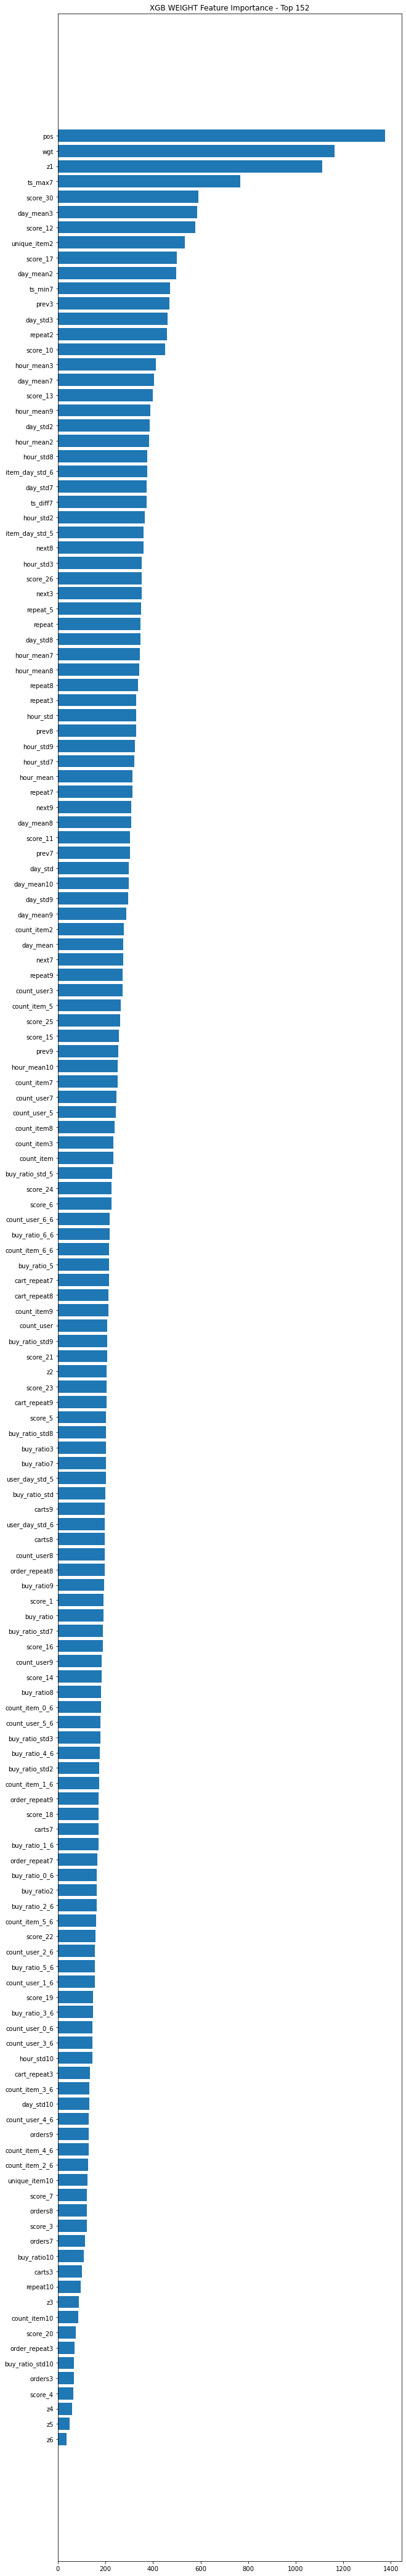

In [13]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
#df.to_csv(f'feats_weight_{USE}_{VER}.csv',index=False)
NUM_FEATURES = len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB WEIGHT Feature Importance - Top {NUM_FEATURES}')
plt.show()

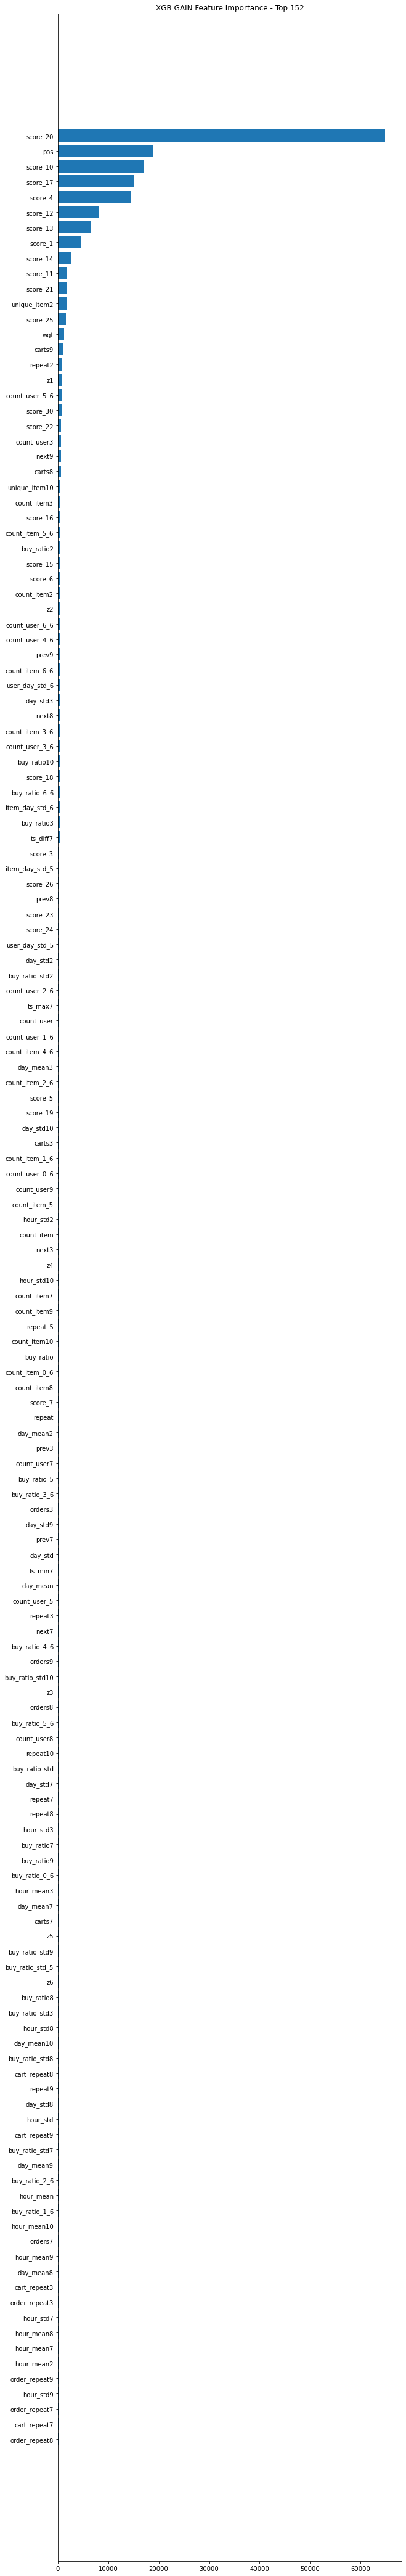

In [14]:
df = importances2[0].copy()
for k in range(1,FOLDS): df = df.merge(importances2[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'feats_gain_{USE}_{VER}.csv',index=False)
NUM_FEATURES = len(df)
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB GAIN Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Make Sub

In [15]:
sub = users[['user','item']].copy()
sub['p'] = oof
#sub = cudf.DataFrame(sub)
sub = sub.sort_values(['user','p'],ascending=[True,False])
print( sub.shape )
sub.head()

(72762057, 3)


,user,item,p
1,11098528,571762,0.320601
2,11098528,1157882,0.260162
0,11098528,884502,0.224231
7,11098528,1718231,0.102646
6,11098528,1586171,0.101651


In [16]:
sub = sub.reset_index(drop=True)

In [17]:
sub['n'] = sub.groupby('user').item.cumcount().astype('int8')

In [18]:
sub.head()

,user,item,p,n
0,11098528,571762,0.320601,0
1,11098528,1157882,0.260162,1
2,11098528,884502,0.224231,2
3,11098528,1718231,0.102646,3
4,11098528,1586171,0.101651,4


In [19]:
sub = sub.loc[sub.n<20]
print( sub.shape )

(36025010, 4)


In [20]:
#sub = sub.to_pandas()

In [21]:
%%time
sub2 = sub.groupby('user').item.apply(list)

CPU times: user 32.1 s, sys: 917 ms, total: 33 s
Wall time: 33 s


In [22]:
sub2 = sub2.to_frame().reset_index()

In [23]:
%%time
sub2.item = sub2.item.apply(lambda x: " ".join(map(str,x)))

CPU times: user 7.08 s, sys: 152 ms, total: 7.24 s
Wall time: 7.23 s


In [24]:
sub2.columns = ['session_type','labels']

In [25]:
sub2.session_type = sub2.session_type.astype('str')+ f'_{USE}'

In [26]:
sub2.head()

,session_type,labels
0,11098528_clicks,571762 1157882 884502 1718231 1586171 258814 4...
1,11098529_clicks,1105029 459126 1383767 612829 1544564 297916 5...
2,11098530_clicks,963957 1212185 1677181 1057886 93444 1268065 3...
3,11098531_clicks,396199 1271998 1365569 624163 698990 1553691 1...
4,11098532_clicks,876469 7651 1202618 476681 1767768 315195 1833...


In [27]:
submission = sub2

In [28]:
%%time
submission['session'] = submission.session_type.apply(lambda x: int(x.split('_')[0]))
submission['type'] = submission.session_type.apply(lambda x: x.split('_')[1])
submission.labels = submission.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])

test_labels = pd.read_parquet('/raid/Kaggle/otto/valid/test_labels.parquet')
test_labels = test_labels.loc[test_labels['type']==USE]
test_labels = test_labels.merge(submission, how='left', on=['session', 'type'])
test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)

recall_per_type = test_labels.groupby(['type'])['hits'].sum() / test_labels.groupby(['type'])['gt_count'].sum() 

score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()
print( score , recall_per_type)

#clicks 0.556975

#clicks 0.55835 v186 leak free

0.06359751505809629 type
clicks    0.635975
dtype: float64
CPU times: user 57.9 s, sys: 1.15 s, total: 59 s
Wall time: 59 s


In [29]:
0.3*4401 + 0.1*5570 + 0.6*6682

5886.5